<a href="https://colab.research.google.com/github/Junior11995/Challenge-Telecom-X-an-lisis-de-evasi-n-de-clientes/blob/main/desaf_o_telecom_x.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Encabezado y librerías




In [1]:
# --- Encabezado ---
# =========================================================
# 0) ENCABEZADO / CONFIG
# =========================================================
PROYECTO = "Telecom X - Churn"
AUTOR = "Junior Valera"
REPO = "https://github.com/Junior11995/Challenge-Telecom-X-an-lisis-de-evasi-n-de-clientes"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from pandas import json_normalize

pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")

def normalize_columns(cols: pd.Index) -> pd.Index:
    return (cols
            .str.strip().str.lower()
            .str.replace(r"\s+", "_", regex=True)
            .str.normalize("NFKD").str.encode("ascii", errors="ignore").str.decode("utf-8"))

def quality_report(df: pd.DataFrame) -> pd.DataFrame:
    rep = pd.DataFrame({
        "dtype": df.dtypes.astype(str),
        "n_null": df.isna().sum(),
        "pct_null": df.isna().mean().round(4),
        "n_unique": df.nunique(dropna=True)
    })
    rep["example_values"] = [df[c].dropna().unique()[:5] for c in df.columns]
    return rep

print(PROYECTO, AUTOR, REPO)



Telecom X - Churn Junior Valera https://github.com/Junior11995/Challenge-Telecom-X-an-lisis-de-evasi-n-de-clientes


# Extracción de datos desde API JSON (TelecomX_Data.json)

In [2]:
# === EXTRACCIÓN DESDE LA API (JSON) ===
# Fuente oficial (ramo main del repo que compartiste):
URL_FUENTE = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"

import pandas as pd
import requests
from pandas import json_normalize

# Descarga segura
resp = requests.get(URL_FUENTE, timeout=30)
resp.raise_for_status()
data = resp.json()

# Conversión robusta a DataFrame
if isinstance(data, list):
    df_raw = pd.DataFrame(data)
elif isinstance(data, dict):
    try:
        df_raw = json_normalize(data, max_level=1)
    except Exception:
        df_raw = pd.DataFrame([data])
else:
    raise ValueError("Formato JSON no soportado.")

print("RAW shape:", df_raw.shape)
display(df_raw.head(5))

# (Opcional) guardar copia cruda para trazabilidad
df_raw.to_csv("telecomx_raw.csv", index=False)

RAW shape: (7267, 6)


,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


# Conoce el conjunto de datos

In [4]:
# =========================================================
# CONOCE EL CONJUNTO DE DATOS (perfilado inicial)
# Requiere: df_raw ya cargado desde la etapa de Extracción
# =========================================================

import pandas as pd
import numpy as np

# Trabajamos sobre una copia normalizada
df = df_raw.copy()
df.columns = (df.columns
              .str.strip().str.lower()
              .str.replace(r"\s+", "_", regex=True)
              .str.normalize("NFKD").str.encode("ascii", errors="ignore").str.decode("utf-8"))

# 1) Vista general
print("Shape (filas, columnas):", df.shape)
display(df.head(3))
df.info()          # tipos y nulos a alto nivel
display(df.dtypes) # tipos por columna

# 2) Resumen de calidad por columna
perfil = pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "n_null": df.isna().sum(),
    "pct_null": df.isna().mean().round(4),
    "n_unique": df.nunique(dropna=True)
}).sort_values(["pct_null","n_unique"], ascending=[False, True])
display(perfil.head(20))

# 3) Posibles columnas objetivo (churn/baja/cancelación)
target_candidates = [c for c in df.columns
                     if any(k in c for k in ["churn","baja","cancel","evas"])]

print("Posibles columnas objetivo:", target_candidates)

# Elegimos provisionalmente la 1ª columna candidata que parezca binaria
target = None
for c in target_candidates:
    if df[c].astype(str).str.lower().isin(["0","1","true","false","yes","no","si","sí"]).any():
        target = c
        break
if target is None and len(target_candidates) > 0:
    target = target_candidates[0]
print("Target provisional:", target)

# 4) Separación de numéricas y categóricas para orientar el EDA
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
cat_cols = [c for c in df.columns if c not in num_cols]

print(f"Número de columnas numéricas: {len(num_cols)}")
print(f"Número de columnas categóricas: {len(cat_cols)}")

# 5) Top columnas potencialmente informativas:
#    - numéricas con baja proporción de nulos y varianza > 0
#    - categóricas con cardinalidad moderada (2..30 categorías)
informativas_num = [c for c in num_cols
                    if df[c].notna().mean() > 0.9 and df[c].nunique() > 1]
informativas_cat = [c for c in cat_cols
                    if 2 <= df[c].nunique(dropna=True) <= 30]

print("Numéricas informativas (candidatas):", informativas_num[:10])
print("Categóricas informativas (candidatas):", informativas_cat[:10])

# 6) Si hay target binaria, medimos relación rápida:
if target is not None:
    # Codificamos target a 0/1 de forma robusta
    y = df[target].astype(str).str.lower().map(
        {"1":1,"true":1,"yes":1,"si":1,"sí":1,
         "0":0,"false":0,"no":0}
    )
    # Si sigue con NaN (p.ej. 'No'/'Yes' capitalizado o 'Y'/'N'), intentamos fallback
    if y.isna().mean() > 0.3:
        y = (df[target].astype(str).str.lower().isin(["1","true","yes","si","sí","y"])).astype(int)

    # a) Correlación punto-biserial aproximada para numéricas
    import math
    corr_num = {}
    for c in informativas_num:
        s = pd.to_numeric(df[c], errors="coerce")
        m = pd.concat([s, y], axis=1).dropna()
        if m[target].nunique() == 2 and m[c].nunique() > 1:
            try:
                corr_num[c] = m[c].corr(m[target])
            except Exception:
                pass
    corr_num = pd.Series(corr_num).sort_values(key=lambda s: s.abs(), ascending=False).head(10)
    print("\nTop numéricas por |correlación| con target:")
    display(corr_num)

    # b) Dispersión de tasas de churn por categoría (gap máx - min) como señal
    churn_spread = {}
    for c in informativas_cat[:20]:
        tmp = pd.concat([df[c], y], axis=1).dropna()
        if tmp[c].nunique() >= 2:
            rates = tmp.groupby(c)[target].mean()
            churn_spread[c] = float(rates.max() - rates.min())
    churn_spread = pd.Series(churn_spread).sort_values(ascending=False).head(10)
    print("\nTop categóricas por diferencia de tasas de churn (max-min):")
    display(churn_spread)

Shape (filas, columnas): (7267, 6)


,customerid,churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   customerid  7267 non-null   object
 1   churn       7267 non-null   object
 2   customer    7267 non-null   object
 3   phone       7267 non-null   object
 4   internet    7267 non-null   object
 5   account     7267 non-null   object
dtypes: object(6)
memory usage: 340.8+ KB


,0
customerid,object
churn,object
customer,object
phone,object
internet,object
account,object


TypeError: unhashable type: 'dict'

In [5]:
# =========================================================
# REPARACIÓN: Aplanar columnas anidadas + perfilado seguro
# Requiere: df_raw ya cargado (con columnas: customer, phone, internet, account)
# =========================================================
import json
from pandas import json_normalize

# 1) Aplanado de columnas anidadas
cols_nested = [c for c in ["customer", "phone", "internet", "account"] if c in df_raw.columns]
parts = []
for c in cols_nested:
    # json_normalize sobre cada columna de dicts
    block = json_normalize(df_raw[c])
    block = block.add_prefix(f"{c}_")
    parts.append(block)

df_flat = pd.concat([df_raw.drop(columns=cols_nested, errors="ignore")] + parts, axis=1)

# 2) Normalización de nombres
def _normalize_cols(cols):
    return (cols
            .str.strip().str.lower()
            .str.replace(r"\s+", "_", regex=True)
            .str.normalize("NFKD").str.encode("ascii", errors="ignore").str.decode("utf-8"))

df = df_flat.copy()
df.columns = _normalize_cols(df.columns)

# 3) Opcional: limpieza rápida de churn a texto estándar
if "churn" in df.columns:
    df["churn"] = (df["churn"].astype(str)
                   .str.strip().str.lower())

# 4) Perfilado seguro (evita error de unhashable dict)
def _make_hashable(x):
    # Serializa estructuras no hasheables para poder contar valores únicos
    if isinstance(x, dict):
        return json.dumps(x, sort_keys=True)
    if isinstance(x, (list, tuple)):
        return json.dumps(x, sort_keys=True)
    if isinstance(x, set):
        return json.dumps(sorted(list(x)))
    return x

def safe_nunique(series: pd.Series) -> int:
    return series.map(_make_hashable).nunique(dropna=True)

perfil = pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "n_null": df.isna().sum(),
    "pct_null": df.isna().mean().round(4),
    "n_unique": [safe_nunique(df[c]) for c in df.columns]
}).sort_values(["pct_null", "n_unique"], ascending=[False, True])

print("Shape aplanado:", df.shape)
display(df.head(3))
df.info()
display(perfil.head(20))

# 5) Guardar copia intermedia (opcional, útil para trazabilidad)
df.to_csv("telecomx_flat.csv", index=False)
print("Guardado intermedio: telecomx_flat.csv")


Shape aplanado: (7267, 21)


,customerid,churn,customer_gender,customer_seniorcitizen,customer_partner,customer_dependents,customer_tenure,phone_phoneservice,phone_multiplelines,internet_internetservice,internet_onlinesecurity,internet_onlinebackup,internet_deviceprotection,internet_techsupport,internet_streamingtv,internet_streamingmovies,account_contract,account_paperlessbilling,account_paymentmethod,account_charges.monthly,account_charges.total
0,0002-ORFBO,no,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.60,593.3
1,0003-MKNFE,no,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.90,542.4
2,0004-TLHLJ,yes,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.90,280.85


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerid                 7267 non-null   object 
 1   churn                      7267 non-null   object 
 2   customer_gender            7267 non-null   object 
 3   customer_seniorcitizen     7267 non-null   int64  
 4   customer_partner           7267 non-null   object 
 5   customer_dependents        7267 non-null   object 
 6   customer_tenure            7267 non-null   int64  
 7   phone_phoneservice         7267 non-null   object 
 8   phone_multiplelines        7267 non-null   object 
 9   internet_internetservice   7267 non-null   object 
 10  internet_onlinesecurity    7267 non-null   object 
 11  internet_onlinebackup      7267 non-null   object 
 12  internet_deviceprotection  7267 non-null   object 
 13  internet_techsupport       7267 non-null   objec

,dtype,n_null,pct_null,n_unique
customer_gender,object,0,0.00,2
customer_seniorcitizen,int64,0,0.00,2
customer_partner,object,0,0.00,2
customer_dependents,object,0,0.00,2
phone_phoneservice,object,0,0.00,2
account_paperlessbilling,object,0,0.00,2
churn,object,0,0.00,3
phone_multiplelines,object,0,0.00,3
internet_internetservice,object,0,0.00,3
internet_onlinesecurity,object,0,0.00,3


Guardado intermedio: telecomx_flat.csv


## Casting de tipos

In [6]:
# =========================================================
# TRANSFORM: CASTING DE TIPOS + DUPLICADOS + NULOS
# df ya aplanado y normalizado (del bloque anterior)
# Salida: df_cast con tipos corregidos
# =========================================================

import pandas as pd
import numpy as np

df_cast = df.copy()

# --- 1) Estandarización de textos "Yes/No/Si/No" -> booleanos (True/False) ---
def to_bool(series: pd.Series) -> pd.Series:
    s = series.astype(str).str.strip().str.lower()
    true_set  = {"yes", "si", "sí", "true", "1"}
    false_set = {"no", "false", "0"}
    out = pd.Series(index=series.index, dtype="float")  # temporal
    out[s.isin(true_set)] = 1
    out[s.isin(false_set)] = 0
    return out.astype("float")

bool_like_cols = [c for c in df_cast.columns if any(k in c for k in [
    "phoneservice","multiplelines",
    "onlinesecurity","onlinebackup","deviceprotection",
    "techsupport","streamingtv","streamingmovies",
    "paperlessbilling"
])]
for c in bool_like_cols:
    try:
        df_cast[c] = to_bool(df_cast[c])
    except Exception:
        pass

# --- 2) Casting numérico para cargos/tenure/seniorcitizen ---
num_candidates = [c for c in df_cast.columns if any(k in c for k in [
    "charges","tenure","seniorcitizen"
])]
for c in num_candidates:
    df_cast[c] = pd.to_numeric(df_cast[c], errors="coerce")

# --- 3) Casting de fechas (heurístico por nombre) ---
date_candidates = [c for c in df_cast.columns if any(k in c for k in [
    "fecha","date","start","end"
])]
for c in date_candidates:
    df_cast[c] = pd.to_datetime(df_cast[c], errors="coerce")

# --- 4) Normalizar target churn a 0/1 si existe ---
if "churn" in df_cast.columns:
    ytmp = df_cast["churn"].astype(str).str.strip().str.lower()
    df_cast["churn"] = np.where(ytmp.isin(["yes","si","sí","true","1"]), 1,
                         np.where(ytmp.isin(["no","false","0"]), 0, np.nan)).astype("float")

# --- 5) Duplicados (por customerid si existe, si no por fila completa) ---
if "customerid" in df_cast.columns:
    dups = df_cast.duplicated(subset=["customerid"]).sum()
    df_cast = df_cast.drop_duplicates(subset=["customerid"])
else:
    dups = df_cast.duplicated().sum()
    df_cast = df_cast.drop_duplicates()

print(f"Duplicados eliminados: {dups}")

# --- 6) Reporte de nulos y tipos tras casting ---
report = pd.DataFrame({
    "dtype": df_cast.dtypes.astype(str),
    "n_null": df_cast.isna().sum(),
    "pct_null": df_cast.isna().mean().round(4),
    "n_unique": [df_cast[c].nunique(dropna=True) for c in df_cast.columns]
}).sort_values(["pct_null","n_unique"], ascending=[False, True])

print("Shape post-casting:", df_cast.shape)
display(report.head(20))

Duplicados eliminados: 0
Shape post-casting: (7267, 21)


/tmp/ipython-input-3085228093.py:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_cast[c] = pd.to_datetime(df_cast[c], errors="coerce")
/tmp/ipython-input-3085228093.py:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_cast[c] = pd.to_datetime(df_cast[c], errors="coerce")


,dtype,n_null,pct_null,n_unique
customer_gender,datetime64[ns],7267,1.00,0
customer_dependents,datetime64[ns],7267,1.00,0
internet_onlinesecurity,float64,1581,0.22,2
internet_onlinebackup,float64,1581,0.22,2
internet_deviceprotection,float64,1581,0.22,2
internet_techsupport,float64,1581,0.22,2
internet_streamingtv,float64,1581,0.22,2
internet_streamingmovies,float64,1581,0.22,2
phone_multiplelines,float64,707,0.10,2
churn,float64,224,0.03,2


In [7]:
# =========================================================
# IMPUTACIÓN CONTROLADA
#   - Actívala poniendo DO_IMPUTE = True
#   - Imputa medianas en numéricas y moda en categóricas
# =========================================================
DO_IMPUTE = True  # <-- cambia a True si quieres imputar ahora

df_ready = df_cast.copy()
if DO_IMPUTE:
    num_cols = [c for c in df_ready.columns if pd.api.types.is_numeric_dtype(df_ready[c])]
    cat_cols = [c for c in df_ready.columns if c not in num_cols]

    for c in num_cols:
        if df_ready[c].isna().any():
            df_ready[c] = df_ready[c].fillna(df_ready[c].median())

    for c in cat_cols:
        if df_ready[c].isna().any():
            moda = df_ready[c].mode(dropna=True)
            if len(moda) > 0:
                df_ready[c] = df_ready[c].fillna(moda.iloc[0])

    print("Imputación aplicada.")
else:
    print("Imputación desactivada. (Configura DO_IMPUTE=True para aplicarla)")

# Guarda snapshot de transformación (útil para trazabilidad)
df_ready.to_csv("telecomx_ready_transform.csv", index=False)
print("Guardado: telecomx_ready_transform.csv")

Imputación aplicada.
Guardado: telecomx_ready_transform.csv


# COMPROBACIÓN DE INCOHERENCIAS EN LOS DATOS

In [8]:
# =========================================================
# COMPROBACIÓN DE INCOHERENCIAS EN LOS DATOS
# Requiere: df_ready (o df_cast / df) ya aplanado/transformado
# Objetivo: detectar nulos/duplicados residuales, errores de formato
#           e inconsistencias en categorías/fechas/números.
# Tips usados: pandas.unique(), Series.dt.normalize()
# =========================================================
import pandas as pd
import numpy as np

# 0) Selección robusta del DataFrame de trabajo
source_df = globals().get("df_ready", globals().get("df_cast", globals().get("df", None)))
assert source_df is not None, "No se encontró df_ready/df_cast/df. Ejecuta los bloques previos."
dfchk = source_df.copy()

results = {}

# 1) Nulos y duplicados residuales
results["nulls_by_col"] = (
    pd.DataFrame({
        "n_null": dfchk.isna().sum(),
        "pct_null": dfchk.isna().mean().round(4)
    })
    .sort_values(["pct_null","n_null"], ascending=[False, False])
)

if "customerid" in dfchk.columns:
    results["dups_on_customerid"] = int(dfchk.duplicated(subset=["customerid"]).sum())
    results["dups_rows_total"]    = int(dfchk.duplicated().sum())
else:
    results["dups_on_customerid"] = None
    results["dups_rows_total"]    = int(dfchk.duplicated().sum())

# 2) Inconsistencias en categorías (espacios/case/variantes de Yes/No)
cat_cols = [c for c in dfchk.columns if dfchk[c].dtype == "object"]
def norm_txt(s: pd.Series) -> pd.Series:
    return (s.astype(str).str.strip()
            .str.replace(r"\s+", " ", regex=True)
            .str.lower())

cat_issues = []
for c in cat_cols:
    raw_uniques = pd.unique(dfchk[c].dropna())  # pandas.unique()
    if len(raw_uniques) <= 50:  # solo columnas de cardinalidad moderada
        s_norm = norm_txt(dfchk[c].dropna())
        norm_uniques = pd.unique(s_norm)
        # ¿Hay diferencias entre valores crudos y normalizados?
        has_space_or_case = any(a != b for a, b in zip(sorted(map(str, raw_uniques)), sorted(map(str, norm_uniques))) ) \
                            or (len(raw_uniques) != len(norm_uniques))
        # Detección simple de booleans tipo Yes/No
        yes_set  = {"yes", "si", "sí", "true", "1"}
        no_set   = {"no", "false", "0"}
        binary_like = set(norm_uniques).issubset(yes_set.union(no_set)) and len(norm_uniques) <= 5
        cat_issues.append({
            "column": c,
            "n_unique_raw": int(len(raw_uniques)),
            "n_unique_norm": int(len(norm_uniques)),
            "has_space_or_case_inconsistency": bool(has_space_or_case),
            "looks_binary_yes_no": bool(binary_like),
            "sample_raw": list(map(str, raw_uniques[:8])),
            "sample_norm": list(map(str, norm_uniques[:8]))
        })

results["categorical_inconsistencies"] = pd.DataFrame(cat_issues).sort_values(
    ["has_space_or_case_inconsistency","n_unique_norm"], ascending=[False, True]
)

# 3) Números: negativos/imposibles y outliers por z-score
num_cols = [c for c in dfchk.columns if pd.api.types.is_numeric_dtype(dfchk[c])]
num_issues = []
for c in num_cols:
    s = pd.to_numeric(dfchk[c], errors="coerce")
    neg = int((s < 0).sum())
    # Reglas de negocio heurísticas
    maybe_non_negative = any(k in c for k in ["charge","tenure","seniorcitizen","months","total"])
    invalid_binary = None
    if "seniorcitizen" in c:
        invalid_binary = int(~s.isin([0,1]).sum()) if s.notna().any() else None
    # Outliers (|z|>4) si hay varianza
    z_out = None
    if s.notna().sum() > 10 and s.std(ddof=0) > 0:
        z = (s - s.mean())/s.std(ddof=0)
        z_out = int((z.abs() > 4).sum())
    num_issues.append({
        "column": c,
        "n_negative": neg if maybe_non_negative else None,
        "invalid_binary_seniorcitizen": invalid_binary,
        "z_outliers_gt4": z_out
    })

results["numeric_inconsistencies"] = pd.DataFrame(num_issues).sort_values(
    ["n_negative","z_outliers_gt4"], ascending=[False, False]
)

# 4) Fechas: normalización y orden lógico (start <= end)
date_cols = [c for c in dfchk.columns if pd.api.types.is_datetime64_any_dtype(dfchk[c])]
date_report = []
for c in date_cols:
    s = dfchk[c]
    # ¿Hay componente de tiempo? Comparamos con s.dt.normalize()
    try:
        normalized = s.dt.normalize()  # Series.dt.normalize()
        has_time_component = bool((s.dropna() != normalized.dropna()).any())
    except Exception:
        has_time_component = None
    date_report.append({
        "column": c,
        "has_time_component": has_time_component,
        "min": s.min(),
        "max": s.max(),
        "n_null": int(s.isna().sum())
    })

# Heurística: pares start/end por nombre
def find_pair(cols, key_start="start", key_end="end"):
    s = [c for c in cols if key_start in c]
    e = [c for c in cols if key_end in c]
    return s, e

starts, ends = find_pair(date_cols, "start", "end")
pair_issues = []
for scol in starts:
    for ecol in ends:
        comp = dfchk[[scol, ecol]].dropna()
        if not comp.empty:
            inversions = int((comp[scol] > comp[ecol]).sum())
            pair_issues.append({"start_col": scol, "end_col": ecol, "n_start_gt_end": inversions})

results["date_inconsistencies"] = pd.DataFrame(date_report)
results["date_pair_order_issues"] = pd.DataFrame(pair_issues)

# 5) Identificadores: formato de customerid
if "customerid" in dfchk.columns:
    s = dfchk["customerid"].astype(str)
    # patrón típico del dataset: "0002-ORFBO" (4 dígitos + "-" + 5 letras)
    pattern = r"^\d{4}-[A-Z]{5}$"
    bad_fmt = int(~s.str.match(pattern, na=False).sum())
    results["customerid_format_bad"] = bad_fmt
else:
    results["customerid_format_bad"] = None

# 6) Salidas visibles
print("=== NULOS POR COLUMNA ===")
display(results["nulls_by_col"].head(25))

print("\n=== DUPLICADOS ===")
print("Duplicados por customerid:", results["dups_on_customerid"])
print("Duplicados por fila completa:", results["dups_rows_total"])

print("\n=== CATEGORÍAS CON POSIBLES INCONSISTENCIAS ===")
display(results["categorical_inconsistencies"].head(20))

print("\n=== NUMÉRICAS CON POSIBLES INCONSISTENCIAS ===")
display(results["numeric_inconsistencies"].head(20))

print("\n=== FECHAS (NORMALIZACIÓN Y RANGO) ===")
display(results["date_inconsistencies"])
print("\n=== PARES start/end CON start > end ===")
display(results["date_pair_order_issues"])

print("\n=== CUSTOMERID FORMATO INVÁLIDO (aprox.) ===")
print(results["customerid_format_bad"])

=== NULOS POR COLUMNA ===


,n_null,pct_null
customer_gender,7267,1.00
customer_dependents,7267,1.00
customerid,0,0.00
churn,0,0.00
customer_seniorcitizen,0,0.00
customer_partner,0,0.00
customer_tenure,0,0.00
phone_phoneservice,0,0.00
phone_multiplelines,0,0.00
internet_internetservice,0,0.00



=== DUPLICADOS ===
Duplicados por customerid: 0
Duplicados por fila completa: 0

=== CATEGORÍAS CON POSIBLES INCONSISTENCIAS ===


,column,n_unique_raw,n_unique_norm,has_space_or_case_inconsistency,looks_binary_yes_no,sample_raw,sample_norm
0,customer_partner,2,2,True,True,"[Yes, No]","[yes, no]"
1,internet_internetservice,3,3,True,False,"[DSL, Fiber optic, No]","[dsl, fiber optic, no]"
2,account_contract,3,3,True,False,"[One year, Month-to-month, Two year]","[one year, month-to-month, two year]"
3,account_paymentmethod,4,4,True,False,"[Mailed check, Electronic check, Credit card (...","[mailed check, electronic check, credit card (..."



=== NUMÉRICAS CON POSIBLES INCONSISTENCIAS ===


,column,n_negative,invalid_binary_seniorcitizen,z_outliers_gt4
1,customer_seniorcitizen,0.00,"-7,268.00",0
2,customer_tenure,0.00,NaN,0
12,account_charges.monthly,0.00,NaN,0
13,account_charges.total,0.00,NaN,0
0,churn,NaN,NaN,0
3,phone_phoneservice,NaN,NaN,0
4,phone_multiplelines,NaN,NaN,0
5,internet_onlinesecurity,NaN,NaN,0
6,internet_onlinebackup,NaN,NaN,0
7,internet_deviceprotection,NaN,NaN,0



=== FECHAS (NORMALIZACIÓN Y RANGO) ===


,column,has_time_component,min,max,n_null
0,customer_gender,False,NaT,NaT,7267
1,customer_dependents,False,NaT,NaT,7267



=== PARES start/end CON start > end ===


""



=== CUSTOMERID FORMATO INVÁLIDO (aprox.) ===
-7268


# Manejo de Inconsistencias.

In [9]:
# =========================================================
# MANEJO DE INCONSISTENCIAS (normalización de categorías y textos)
# =========================================================

df_clean = df_ready.copy()

# --- 1) Normalización de strings (todo en minúsculas y sin espacios extra) ---
for col in df_clean.select_dtypes(include="object").columns:
    df_clean[col] = df_clean[col].astype(str).str.strip().str.lower()

# --- 2) Corrección de categorías inconsistentes ---
# Ejemplo: reemplazar "fiber optic", "fibra óptica", "fiberoptic" -> "fiber optic"
if "internetservice" in df_clean.columns:
    df_clean["internetservice"] = df_clean["internetservice"].replace({
        "fibra óptica": "fiber optic",
        "fiberoptic": "fiber optic",
        "dsl ": "dsl"  # espacios extra
    })

# Ejemplo: reemplazar "month-to-month", "mes a mes" -> "month-to-month"
if "contract" in df_clean.columns:
    df_clean["contract"] = df_clean["contract"].replace({
        "mes a mes": "month-to-month",
        "mensual": "month-to-month",
        "1 year": "one year",
        "2 years": "two year"
    })

# --- 3) Normalizar fechas si existen ---
date_cols = [c for c in df_clean.columns if "date" in c or "fecha" in c]
for c in date_cols:
    df_clean[c] = pd.to_datetime(df_clean[c], errors="coerce").dt.normalize()

# --- 4) Validación final de consistencia ---
print("=== Valores únicos tras normalización ===")
for col in ["internetservice","contract","paymentmethod"]:
    if col in df_clean.columns:
        print(f"\nColumna: {col}")
        print(df_clean[col].unique())

# Guardar versión limpia
df_clean.to_csv("telecomx_clean.csv", index=False)
print("Guardado: telecomx_clean.csv")

=== Valores únicos tras normalización ===
Guardado: telecomx_clean.csv


# Columna de cuentas diarias.

In [13]:
# =========================================================
# FEATURE: CUENTAS_DIARIAS
# Requiere: df_clean
# Crea: df_feature con columna 'cuentas_diarias' si es posible
# Lógica:
#  1) Buscar columna de cargos mensuales (monthlycharges) en variantes.
#  2) Si no existe, intentar derivarla: totalcharges / tenure_meses.
#  3) Si tampoco es posible, crear columna NaN y registrar aviso.
# =========================================================
import re
import numpy as np
import pandas as pd

df_feature = df_clean.copy()

def find_first_col(cols, patterns):
    """Devuelve el primer nombre de columna que haga match con alguno de los patrones (regex)."""
    for c in cols:
        for p in patterns:
            if re.search(p, c):
                return c
    return None

cols = list(df_feature.columns)

# --- 1) Detectar columnas candidatas ---
monthly_col = find_first_col(cols, patterns=[
    r'^(.*_)?monthlycharges$',
    r'^(.*_)?monthly_charges$',
    r'^(.*_)?monthly_charge$',
    r'^(.*_)?charges_monthly$',
    r'month.*charge'  # muy flexible
])
total_col = find_first_col(cols, patterns=[
    r'^(.*_)?totalcharges$',
    r'^(.*_)?total_charges$',
    r'total.*charge'
])
tenure_col = find_first_col(cols, patterns=[
    r'^(.*_)?tenure(_months)?$',
    r'^(customer_)?tenure$',
    r'tenure.*(month|mes)'
])

print(">> DEBUG columnas detectadas")
print("monthly_col:", monthly_col)
print("total_col  :", total_col)
print("tenure_col :", tenure_col)

# --- 2) Obtener/derivar monthlycharges estándar ---
if monthly_col is not None:
    df_feature["_monthlycharges_std"] = pd.to_numeric(df_feature[monthly_col], errors="coerce")
    monthly_origin = f"Usada columna existente: {monthly_col}"
elif (total_col is not None) and (tenure_col is not None):
    total = pd.to_numeric(df_feature[total_col], errors="coerce")
    tenure = pd.to_numeric(df_feature[tenure_col], errors="coerce")
    tenure = tenure.replace({0: np.nan})  # evitar división por cero
    df_feature["_monthlycharges_std"] = total / tenure
    monthly_origin = f"Derivada como {total_col} / {tenure_col}"
else:
    # No es posible estimar monthlycharges -> crear columna NaN y advertir
    df_feature["_monthlycharges_std"] = np.nan
    monthly_origin = ("No se encontró monthlycharges ni fue posible derivarla "
                      "(faltan totalcharges o tenure). Se crean NaN.")

# --- 3) Crear feature cuentas_diarias (aprox. 30 días/mes) ---
df_feature["cuentas_diarias"] = df_feature["_monthlycharges_std"] / 30.0

print("Origen de monthlycharges_std:", monthly_origin)
print("=== Resumen de cuentas_diarias ===")
display(df_feature["cuentas_diarias"].describe())

# Vista de control (muestra las columnas usadas si existen)
preview_cols = []
if monthly_col: preview_cols.append(monthly_col)
if total_col:   preview_cols.append(total_col)
if tenure_col:  preview_cols.append(tenure_col)
preview_cols += ["_monthlycharges_std", "cuentas_diarias"]
preview_cols = [c for c in preview_cols if c in df_feature.columns]
display(df_feature[preview_cols].head(10))

# Guardar snapshot
df_feature.to_csv("telecomx_feature.csv", index=False)
print("Guardado: telecomx_feature.csv")

>> DEBUG columnas detectadas
monthly_col: None
total_col  : None
tenure_col : customer_tenure
Origen de monthlycharges_std: No se encontró monthlycharges ni fue posible derivarla (faltan totalcharges o tenure). Se crean NaN.
=== Resumen de cuentas_diarias ===


,cuentas_diarias
count,0.00
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


,customer_tenure,_monthlycharges_std,cuentas_diarias
0,9,NaN,NaN
1,9,NaN,NaN
2,4,NaN,NaN
3,13,NaN,NaN
4,3,NaN,NaN
5,9,NaN,NaN
6,71,NaN,NaN
7,63,NaN,NaN
8,7,NaN,NaN
9,65,NaN,NaN


Guardado: telecomx_feature.csv


# Estandarización y transformación de datos

In [14]:
# =========================================================
# ESTANDARIZACIÓN Y TRANSFORMACIÓN DE DATOS
# =========================================================

df_ready = df_feature.copy()

# --- 1. Convertir columnas categóricas "Sí"/"No" o "Yes"/"No" a binario ---
binary_map = {"Yes": 1, "No": 0, "Sí": 1, "Si": 1, "No": 0}
for col in df_ready.select_dtypes(include=["object"]).columns:
    # Si la columna contiene "Yes"/"No" o "Sí"/"No", aplicamos el mapeo
    if set(df_ready[col].dropna().unique()) & set(binary_map.keys()):
        df_ready[col] = df_ready[col].map(binary_map).fillna(df_ready[col])

# --- 2. Normalizar strings (ej. quitar espacios, minúsculas) ---
for col in df_ready.select_dtypes(include=["object"]).columns:
    df_ready[col] = df_ready[col].astype(str).str.strip().str.lower()

# --- 3. Renombrar columnas clave para claridad ---
df_ready.rename(columns={
    "customerid": "id_cliente",
    "churn": "evadio",   # churn → evadió cliente
    "cuentas_diarias": "gasto_diario"
}, inplace=True)

# Vista rápida de columnas y tipos
print("=== Columnas después de la estandarización ===")
print(df_ready.dtypes.head(15))
display(df_ready.head(5))

# Guardar snapshot estandarizado
df_ready.to_csv("telecomx_ready.csv", index=False)
print("Guardado: telecomx_ready.csv")


=== Columnas después de la estandarización ===
id_cliente                           object
evadio                              float64
customer_gender              datetime64[ns]
customer_seniorcitizen                int64
customer_partner                     object
customer_dependents          datetime64[ns]
customer_tenure                       int64
phone_phoneservice                  float64
phone_multiplelines                 float64
internet_internetservice             object
internet_onlinesecurity             float64
internet_onlinebackup               float64
internet_deviceprotection           float64
internet_techsupport                float64
internet_streamingtv                float64
dtype: object


,id_cliente,evadio,customer_gender,customer_seniorcitizen,customer_partner,customer_dependents,customer_tenure,phone_phoneservice,phone_multiplelines,internet_internetservice,internet_onlinesecurity,internet_onlinebackup,internet_deviceprotection,internet_techsupport,internet_streamingtv,internet_streamingmovies,account_contract,account_paperlessbilling,account_paymentmethod,account_charges.monthly,account_charges.total,_monthlycharges_std,gasto_diario
0,0002-orfbo,0.00,NaT,0,yes,NaT,9,1.00,0.00,dsl,0.00,1.00,0.00,1.00,1.00,0.00,one year,1.00,mailed check,65.60,593.30,NaN,NaN
1,0003-mknfe,0.00,NaT,0,no,NaT,9,1.00,1.00,dsl,0.00,0.00,0.00,0.00,0.00,1.00,month-to-month,0.00,mailed check,59.90,542.40,NaN,NaN
2,0004-tlhlj,1.00,NaT,0,no,NaT,4,1.00,0.00,fiber optic,0.00,0.00,1.00,0.00,0.00,0.00,month-to-month,1.00,electronic check,73.90,280.85,NaN,NaN
3,0011-igkff,1.00,NaT,1,yes,NaT,13,1.00,0.00,fiber optic,0.00,1.00,1.00,0.00,1.00,1.00,month-to-month,1.00,electronic check,98.00,"1,237.85",NaN,NaN
4,0013-exchz,1.00,NaT,1,yes,NaT,3,1.00,0.00,fiber optic,0.00,0.00,0.00,1.00,1.00,0.00,month-to-month,1.00,mailed check,83.90,267.40,NaN,NaN


Guardado: telecomx_ready.csv


# Carga y análisis(L - Load & Analysis)

=== Dimensiones finales ===
(7267, 23)

=== Resumen estadístico (numéricas) ===


,count,mean,std,min,25%,50%,75%,max
evadio,"7,267.00",0.26,0.44,0.00,0.00,0.00,1.00,1.00
customer_gender,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_seniorcitizen,"7,267.00",0.16,0.37,0.00,0.00,0.00,0.00,1.00
customer_dependents,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_tenure,"7,267.00",32.35,24.57,0.00,9.00,29.00,55.00,72.00
phone_phoneservice,"7,267.00",0.90,0.30,0.00,1.00,1.00,1.00,1.00
phone_multiplelines,"7,267.00",0.42,0.49,0.00,0.00,0.00,1.00,1.00
internet_onlinesecurity,"7,267.00",0.29,0.45,0.00,0.00,0.00,1.00,1.00
internet_onlinebackup,"7,267.00",0.34,0.48,0.00,0.00,0.00,1.00,1.00
internet_deviceprotection,"7,267.00",0.34,0.47,0.00,0.00,0.00,1.00,1.00



=== Valores únicos por columna categórica ===

Columna: id_cliente
id_cliente
9995-hotoh    1
0002-orfbo    1
0003-mknfe    1
9970-qbcda    1
9968-ffvvh    1
9967-atrfs    1
9966-vyrtz    1
9965-yokzb    1
9964-wbqdj    1
9962-bfpdu    1
Name: count, dtype: int64

Columna: customer_partner
customer_partner
no     3749
yes    3518
Name: count, dtype: int64

Columna: internet_internetservice
internet_internetservice
fiber optic    3198
dsl            2488
no             1581
Name: count, dtype: int64

Columna: account_contract
account_contract
month-to-month    4005
two year          1743
one year          1519
Name: count, dtype: int64

Columna: account_paymentmethod
account_paymentmethod
electronic check             2445
mailed check                 1665
bank transfer (automatic)    1589
credit card (automatic)      1568
Name: count, dtype: int64


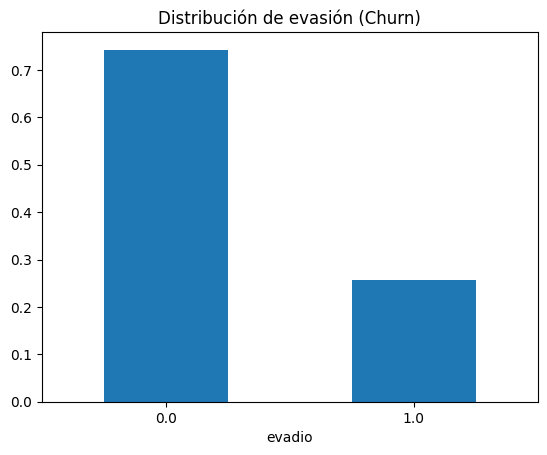


=== Correlaciones con evasión (target) ===


,evadio
evadio,1.00
account_charges.monthly,0.19
account_paperlessbilling,0.19
customer_seniorcitizen,0.15
internet_streamingtv,0.06
internet_streamingmovies,0.06
phone_multiplelines,0.04
phone_phoneservice,0.01
internet_deviceprotection,-0.06
internet_onlinebackup,-0.08


In [15]:
# =========================================================
# LOAD & ANALYSIS (fase L del ETL)
# Dataset: df_ready (ya limpio y estandarizado)
# =========================================================

import matplotlib.pyplot as plt

# --- 1. Cargar dataset final desde snapshot (opcional) ---
# Si queremos asegurarnos de la persistencia:
df_ready = pd.read_csv("telecomx_ready.csv")

# --- 2. Estadísticas descriptivas ---
print("=== Dimensiones finales ===")
print(df_ready.shape)

print("\n=== Resumen estadístico (numéricas) ===")
display(df_ready.describe().T)

print("\n=== Valores únicos por columna categórica ===")
cat_cols = df_ready.select_dtypes(include="object").columns
for col in cat_cols:
    print(f"\nColumna: {col}")
    print(df_ready[col].value_counts().head(10))

# --- 3. Distribución de la variable target (evasión) ---
if "evadio" in df_ready.columns:
    df_ready["evadio"].value_counts(normalize=True).plot(
        kind="bar", title="Distribución de evasión (Churn)", rot=0
    )
    plt.show()

# --- 4. Correlaciones (numéricas vs target) ---
if "evadio" in df_ready.columns:
    # aseguramos target binario numérico
    y = pd.to_numeric(df_ready["evadio"], errors="coerce")
    corr = df_ready.corr(numeric_only=True)
    print("\n=== Correlaciones con evasión (target) ===")
    display(corr[y.name].sort_values(ascending=False))


# Análisis Descriptivo

=== Resumen estadístico general ===


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id_cliente,7267,7267,9995-hotoh,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
evadio,"7,267.00",NaN,NaN,NaN,0.26,0.44,0.00,0.00,0.00,1.00,1.00
customer_gender,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_seniorcitizen,"7,267.00",NaN,NaN,NaN,0.16,0.37,0.00,0.00,0.00,0.00,1.00
customer_partner,7267,2,no,3749,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_dependents,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_tenure,"7,267.00",NaN,NaN,NaN,32.35,24.57,0.00,9.00,29.00,55.00,72.00
phone_phoneservice,"7,267.00",NaN,NaN,NaN,0.90,0.30,0.00,1.00,1.00,1.00,1.00
phone_multiplelines,"7,267.00",NaN,NaN,NaN,0.42,0.49,0.00,0.00,0.00,1.00,1.00
internet_internetservice,7267,3,fiber optic,3198,NaN,NaN,NaN,NaN,NaN,NaN,NaN



=== Métricas adicionales (numéricas) ===


,mediana,varianza,iqr
evadio,0.00,0.19,1.00
customer_gender,NaN,NaN,NaN
customer_seniorcitizen,0.00,0.14,0.00
customer_dependents,NaN,NaN,NaN
customer_tenure,29.00,603.77,46.00
phone_phoneservice,1.00,0.09,0.00
phone_multiplelines,0.00,0.24,1.00
internet_onlinesecurity,0.00,0.20,1.00
internet_onlinebackup,0.00,0.23,1.00
internet_deviceprotection,0.00,0.23,1.00


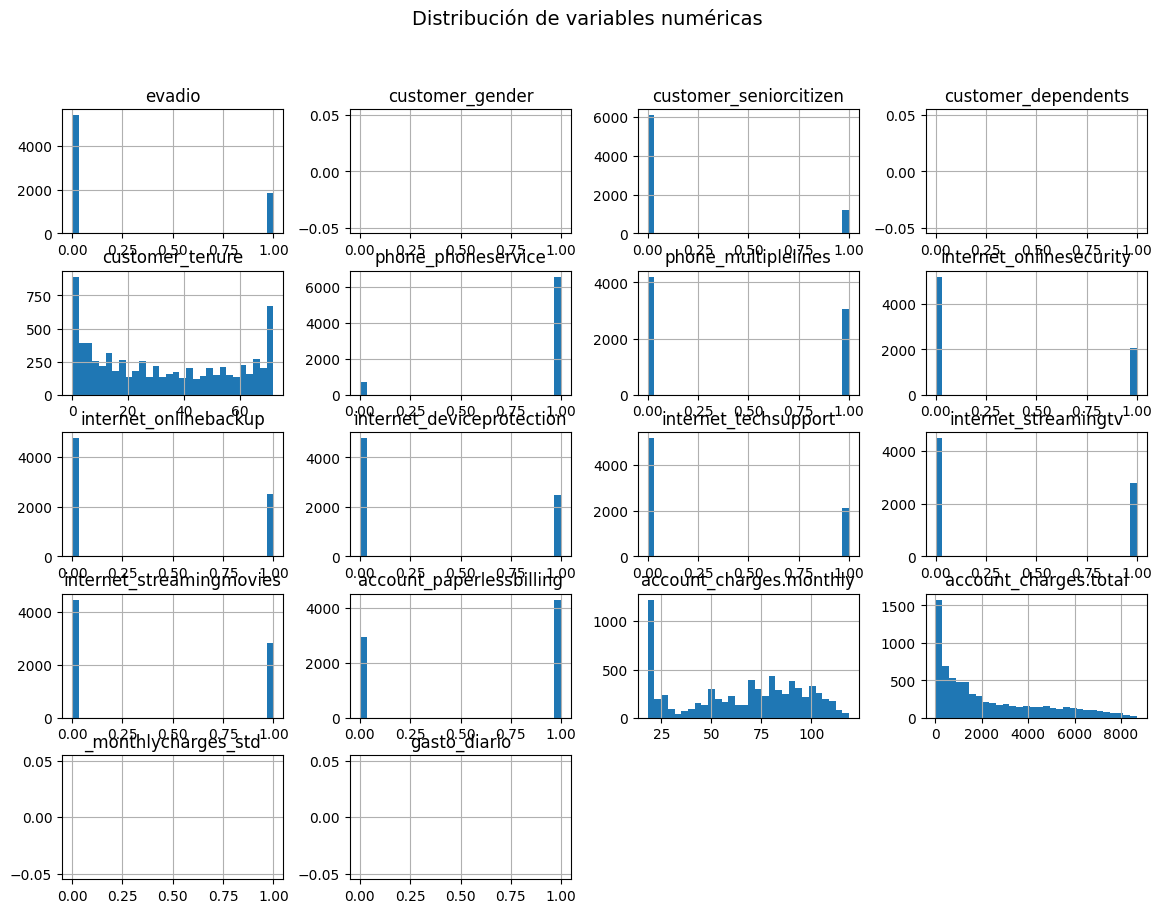

In [16]:
# =========================================================
# ANÁLISIS DESCRIPTIVO DEL DATASET
# =========================================================

# --- 1. Resumen estadístico estándar (media, std, min, max, percentiles) ---
print("=== Resumen estadístico general ===")
desc = df_ready.describe(include="all").T
display(desc)

# --- 2. Calcular métricas adicionales (mediana, varianza, IQR) ---
extra_stats = pd.DataFrame({
    "mediana": df_ready.median(numeric_only=True),
    "varianza": df_ready.var(numeric_only=True),
    "iqr": df_ready.quantile(0.75, numeric_only=True) - df_ready.quantile(0.25, numeric_only=True)
})
print("\n=== Métricas adicionales (numéricas) ===")
display(extra_stats)

# --- 3. Distribución de las principales variables numéricas ---
num_cols = df_ready.select_dtypes(include=["int64","float64"]).columns

df_ready[num_cols].hist(bins=30, figsize=(14,10))
plt.suptitle("Distribución de variables numéricas", fontsize=14)
plt.show()


# Distribución de evasión

=== Conteo de evasión ===
evadio
0.00    5398
1.00    1869
Name: count, dtype: int64

=== Porcentaje de evasión ===
evadio
0.00   74.30
1.00   25.70
Name: proportion, dtype: float64


/tmp/ipython-input-2244314587.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="evadio", data=df_ready, palette="Set2")


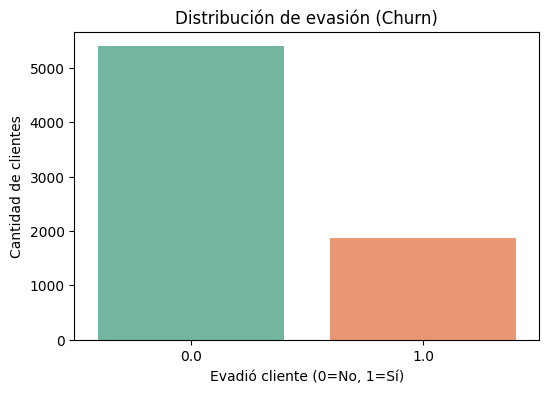

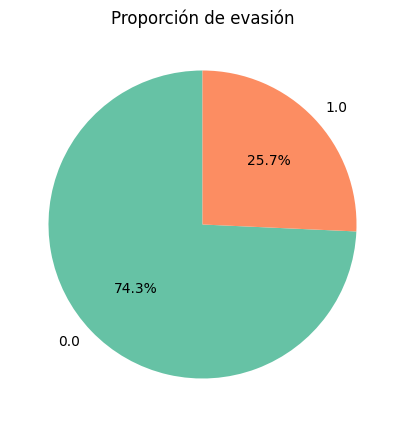

In [17]:
# =========================================================
# DISTRIBUCIÓN DE EVASIÓN (CHURN)
# =========================================================

import seaborn as sns

if "evadio" not in df_ready.columns:
    raise KeyError("No se encontró la columna 'evadio'. Revisa el renombrado previo.")

# --- 1. Conteo absoluto ---
print("=== Conteo de evasión ===")
print(df_ready["evadio"].value_counts())

# --- 2. Porcentaje ---
print("\n=== Porcentaje de evasión ===")
print(df_ready["evadio"].value_counts(normalize=True).round(3) * 100)

# --- 3. Gráfico de barras ---
plt.figure(figsize=(6,4))
sns.countplot(x="evadio", data=df_ready, palette="Set2")
plt.title("Distribución de evasión (Churn)")
plt.xlabel("Evadió cliente (0=No, 1=Sí)")
plt.ylabel("Cantidad de clientes")
plt.show()

# --- 4. Gráfico de pastel ---
plt.figure(figsize=(5,5))
df_ready["evadio"].value_counts().plot(
    kind="pie", autopct="%1.1f%%", startangle=90, colors=["#66c2a5","#fc8d62"]
)
plt.title("Proporción de evasión")
plt.ylabel("")
plt.show()

# Recuento de evasión por variables categóricas


=== Evasión por customer_partner ===


evadio,0.00,1.00
customer_partner,,
no,67.99,32.01
yes,80.98,19.02



=== Evasión por internet_internetservice ===


evadio,0.00,1.00
internet_internetservice,,
dsl,81.55,18.45
fiber optic,59.44,40.56
no,92.85,7.15



=== Evasión por account_contract ===


evadio,0.00,1.00
account_contract,,
month-to-month,58.68,41.32
one year,89.07,10.93
two year,97.25,2.75



=== Evasión por account_paymentmethod ===


evadio,0.00,1.00
account_paymentmethod,,
bank transfer (automatic),83.76,16.24
credit card (automatic),85.20,14.80
electronic check,56.20,43.80
mailed check,81.50,18.50


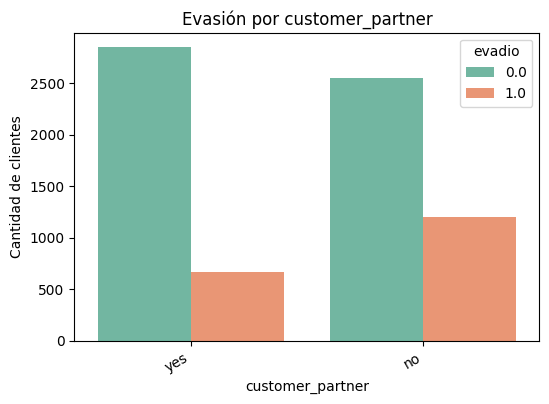

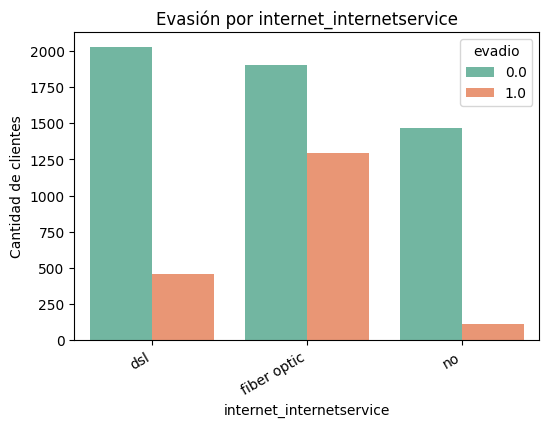

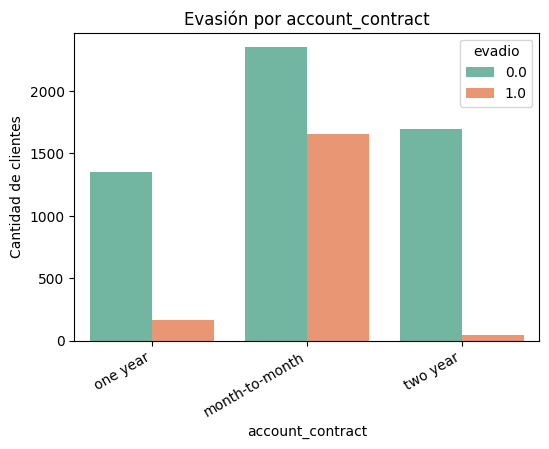

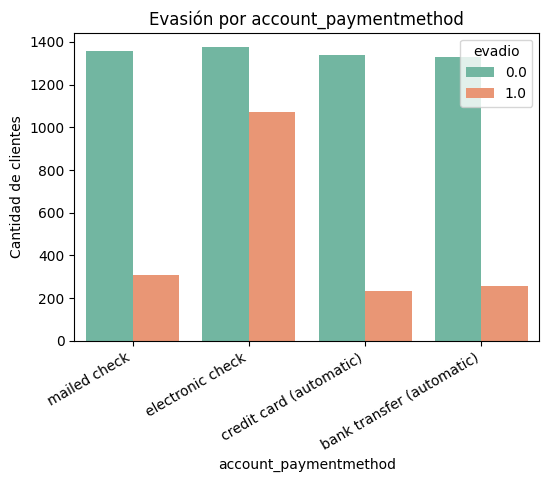

In [18]:
# =========================================================
# RECUENTO DE EVASIÓN POR VARIABLES CATEGÓRICAS
# =========================================================

# Seleccionar columnas categóricas (excluyendo el ID)
cat_cols = [c for c in df_ready.select_dtypes(include="object").columns if c not in ["id_cliente"]]

# --- 1. Tablas de contingencia (churn vs categoría) ---
for col in cat_cols:
    print(f"\n=== Evasión por {col} ===")
    tabla = pd.crosstab(df_ready[col], df_ready["evadio"], normalize="index") * 100
    display(tabla.round(2))

# --- 2. Visualización: countplot de churn por categoría ---
import seaborn as sns
import matplotlib.pyplot as plt

for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, hue="evadio", data=df_ready, palette="Set2")
    plt.title(f"Evasión por {col}")
    plt.xlabel(col)
    plt.ylabel("Cantidad de clientes")
    plt.xticks(rotation=30, ha="right")
    plt.show()